# ReAct(Reasoning and Acting) Simple

- 題材
  - How to use the pre-built ReAct agent( https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/ )
  - ユーザーからの質問に対して適切なツールを実行し、その結果を踏まえた回答を生成する。

- Prebuilt ReAct Agent( https://langchain-ai.github.io/langgraph/how-tos/#prebuilt-react-agent )
  - `LangGraph`ではあらかじめ`ReAct Agent`用にコンパイルされたグラフが`prebuild`として用意されている。
    - 手動で実装する例: How to create a ReAct agent from scratch( https://langchain-ai.github.io/langgraph/how-tos/react-agent-from-scratch/ )
    - 独自のノードとかを追加したい場合はこれを利用するのがよさそう
- LangGraphを用いたAIエージェント"ReAct"の実装( https://qiita.com/t_serizawa/items/0810a2b05c099c08105e )

- ツールの呼び出しには`Tool calling`を利用
  - `Tool calling`( https://langchain-ai.github.io/langgraph/how-tos/#tool-calling )( https://python.langchain.com/docs/concepts/tool_calling/ ) 


(参考)
- langchain-ai/react-agent( https://github.com/langchain-ai/react-agent )

## パッケージインストール

In [1]:
%pip install -qU langgraph langchain-openai python-dotenv

Note: you may need to restart the kernel to use updated packages.


## 環境変数読み込み

In [2]:
from dotenv import load_dotenv
import os

load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_PROJECT"] = "langchain-study"

## モデルの用意

In [3]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

## ツールの用意
`@tool`というデコレーターを用いることでAgentに使用させるツールを定義。  
関数の定義の直後にコメントとして記載されている関数の説明もツールの説明としてLLMに渡される点がポイント。  

- `Tools`( https://python.langchain.com/docs/concepts/tools/ )

ここではダミー関数として2つの関数を実装している。

In [4]:
from typing import Literal
from langchain_core.tools import tool

@tool
def get_weather(city: Literal["Tokyo", "Hokkaido"]) -> str:
    """天候に関する情報を取得するツール"""
    
    if city == "Tokyo":
        return "東京の天気は晴れです。"
    elif city == "Hokkaido":
        return "北海道の天気は曇りです。"
    else:
        raise AssertionError("Unknown city")

@tool
def search_restaurant(dish: str) -> str:
    """レストランに関する情報を取得するツール"""
    if dish == "ハンバーガー":
        return "マクドナルド。"
    elif dish == "ラーメン":
        return "二郎。"
    else:
        raise AssertionError("Unknown dish")

tools = [get_weather, search_restaurant]

## グラフの定義
`create_react_agent()`を使用してグラフを作成することで、`ReAct`に沿ったグラフを作成できる。  
`prebuilt`パッケージに含まれているのでグラフのコンパイルは不要。

- `create_react_agent()`( https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.chat_agent_executor.create_react_agent )

In [5]:
from langgraph.prebuilt import create_react_agent

graph = create_react_agent(model, tools=tools)
# graph = create_react_agent(model, tools=tools, response_format=tuple)  # tupleで結果を取得

## 実行

In [6]:
# inputs = {"messages": [("user", "東京の天気は？")]}         # get_weather()が呼び出される
# inputs = {"messages": [("user", "ラーメンが食べたいな。")]}  # search_restaurant()が呼び出される

inputs = {"messages": [("user", "東京でラーメンが食べたいな。天気も心配だ。")]}  # get_weather()とsearch_restaurant()が呼び出される

result=graph.invoke(inputs)

print("=== 全てのメッセージを表示 ===")
for message in result["messages"]:
    print(f"{message.__class__.__name__}: {message}")

print("=== 最終的な回答のみを表示 ===")
print(result["messages"][-1].content)

=== 全てのメッセージを表示 ===
HumanMessage: content='東京でラーメンが食べたいな。天気も心配だ。' additional_kwargs={} response_metadata={} id='db969b26-b684-4954-950f-d22ad00dd416'
AIMessage: content='' additional_kwargs={'tool_calls': [{'id': 'call_pk2iwSvMbhKzZmIOj25ZKwtV', 'function': {'arguments': '{"dish": "ラーメン"}', 'name': 'search_restaurant'}, 'type': 'function'}, {'id': 'call_jK4d4AH82hLv9Few80LP9jlt', 'function': {'arguments': '{"city": "Tokyo"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 104, 'total_tokens': 153, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0392822090', 'id': 'chatcmpl-BWnJc702ULLaXCFoZuHjz3mVL7RTX', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': N

## グラフの描画

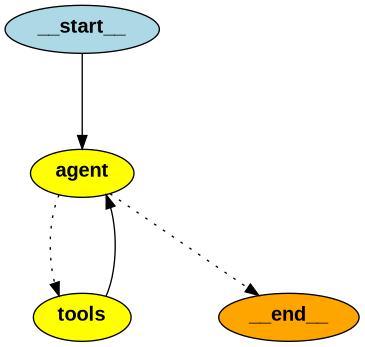

In [7]:
from IPython.display import Image

Image(graph.get_graph().draw_png())